In [1]:
import os
import numpy as np
import pandas as pd

import nltk

from utils import *

import matplotlib.pyplot as plt
from IPython.display import IFrame, display

pd.options.display.max_columns = None

### Read

In [2]:
file1 = "data/articles1.csv"
# filenames = ["data/articles{}.csv".format(n) for n in [1,2,3]]

In [3]:
df = pd.read_csv(file1, encoding='utf-8')
# df['content'] = df.content.str.encode('utf-8')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 10 columns):
Unnamed: 0     50000 non-null int64
id             50000 non-null int64
title          50000 non-null object
publication    50000 non-null object
author         43694 non-null object
date           50000 non-null object
year           50000 non-null float64
month          50000 non-null float64
url            0 non-null float64
content        50000 non-null object
dtypes: float64(3), int64(2), object(5)
memory usage: 3.8+ MB


In [4]:
df.head()

,Unnamed: 0,id,title,publication,author,date,year,month,url,content
0,0,17283,House Republicans Fret About Winning Their Hea...,New York Times,Carl Hulse,2016-12-31,2016.0,12.0,NaN,WASHINGTON — Congressional Republicans have...
1,1,17284,Rift Between Officers and Residents as Killing...,New York Times,Benjamin Mueller and Al Baker,2017-06-19,2017.0,6.0,NaN,"After the bullet shells get counted, the blood..."
2,2,17285,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",New York Times,Margalit Fox,2017-01-06,2017.0,1.0,NaN,"When Walt Disney’s “Bambi” opened in 1942, cri..."
3,3,17286,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",New York Times,William McDonald,2017-04-10,2017.0,4.0,NaN,"Death may be the great equalizer, but it isn’t..."
4,4,17287,Kim Jong-un Says North Korea Is Preparing to T...,New York Times,Choe Sang-Hun,2017-01-02,2017.0,1.0,NaN,"SEOUL, South Korea — North Korea’s leader, ..."


In [5]:
df.publication.value_counts()

Breitbart           23781
CNN                 11488
New York Times       7803
Business Insider     6757
Atlantic              171
Name: publication, dtype: int64

#### Wow that feels like a strange skew towards Breitbart (perhaps because they are more prolific?). Will have to keep this in mind whenever considering relative frequencies

### Gather and preprocess text

#### We are gonna start with handpicked stories about the orlando shooting

In [6]:
# use functions in utils.py to preprocess

In [7]:
# orlando shooting happened on 6/12/2016
df['day'] = df.date.map(lambda d: int(d.split('-')[2]))
other_events_df = df[(df.year == 2016) & (df.month == 6) & (df.day >= 12)].head(4)
other_events = df_to_stringlist(other_events_df)

In [8]:
# ids 20547 and 20550 are for orlando
orlando_stories = df_to_stringlist(df[df.id.isin([20547, 20550])])

In [9]:
# 2 orlando stories followed by non-orlando stories
stories = orlando_stories + other_events
len(stories)
# stories[0]

6

### Analysis

#### Find top words, according to TFIDF, using sklearn or nltk

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer

tfidf_vectorizer = TfidfVectorizer(tokenizer=tokenize, max_df=0.95, min_df=2)# max_features=n_features,
# min and max params: If float, the parameter represents a proportion of documents; if integer, absolute counts.
tfidf = tfidf_vectorizer.fit_transform(stories)

#### A couple things to notice (also sanity check)

In [11]:
labelled_tfidf = pd.DataFrame(data=tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names())

terms_i_care_about_the_most = ['orlando', 'gun', 'shooting', 'terrorist', 'islamic']
labelled_tfidf[terms_i_care_about_the_most]

,orlando,gun,shooting,terrorist,islamic
0,0.217642,0.081616,0.272053,0.108821,0.217642
1,0.154515,0.025752,0.154515,0.051505,0.206020
2,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000


As expected the terms you expect to see in the orlando story are present in the first two but not in the rest. The actual number are not very interesting yet--the actual 'corpus' for the project is the set of articles about gun violence, not a set containing articles about other types of stories

[ 1.          0.72755454  0.15837885  0.17994723  0.11847403  0.20192025]
[ 0.72755454  1.          0.12437024  0.13737382  0.14752895  0.14552583]


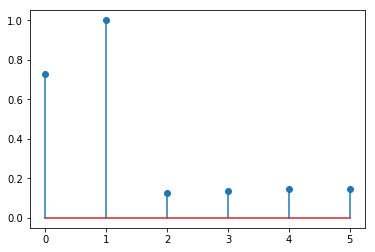

In [12]:
from sklearn.metrics.pairwise import cosine_similarity

similarity = cosine_similarity(tfidf)
print(similarity[0]) # first orlando story
print(similarity[1]) # second orlando story

plt.stem(similarity[1])
plt.show()

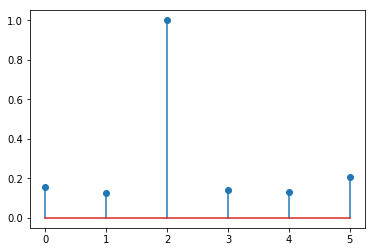

In [13]:
plt.stem(similarity[2])
plt.show()

Also as expected, we see the tfidf similarity to pair the two orlando stories as quite similar relative to the other stories. The later stories are not very similar to any other stories by this measure. 

#### Top words

In [14]:
by_story = labelled_tfidf.T
n_top = 10
top_orlando = by_story[0].sort_values(ascending=False)[:n_top]
top_scotus = by_story[2].sort_values(ascending=False)[:n_top]
top_orlando

shooting       0.272053
group          0.272053
people         0.271956
mateen         0.244848
orlando        0.217642
islamic        0.217642
enforcement    0.163232
law            0.160780
state          0.157459
attack         0.136026
Name: 0, dtype: float64

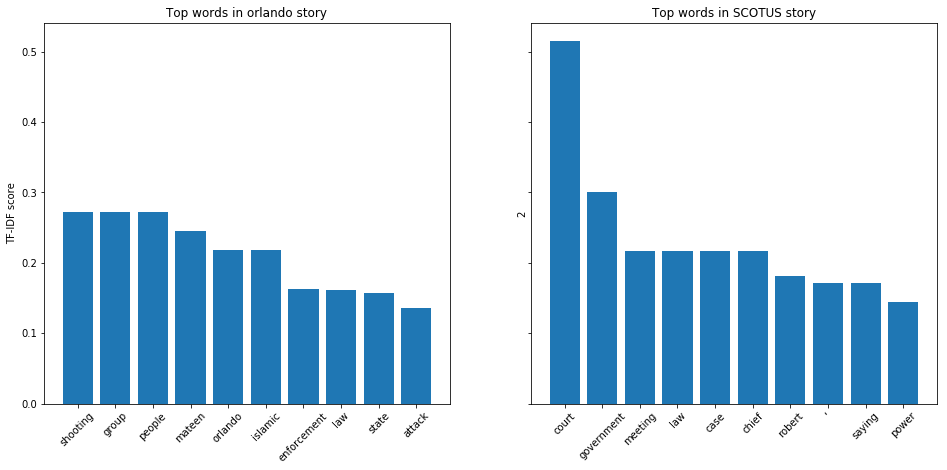

In [30]:
x = range(n_top)

fig, axarr = plt.subplots(1,2,sharey='row', figsize=(16,7))

ax1 = axarr[0]
ax2 = axarr[1]

make_series_bar(ax1, series=top_orlando, title='Top words in orlando story', ylabel='TF-IDF score')
make_series_bar(ax2, series=top_scotus, title='Top words in SCOTUS story')

# plt.savefig('compare_orlando_tfidf_scores.png')
plt.show()

#### Pipeline it and do the same with straight counts

In [17]:
tf_vectorizer = CountVectorizer(tokenizer=tokenize)
tf = tf_vectorizer.fit_transform(stories)
    
labelled_counts = vec_output_to_df(tf_vectorizer, tf)

top_orlando_counts = get_top_by_idx(labelled_counts, 0)
top_scotus_counts = get_top_by_idx(labelled_counts, 2)

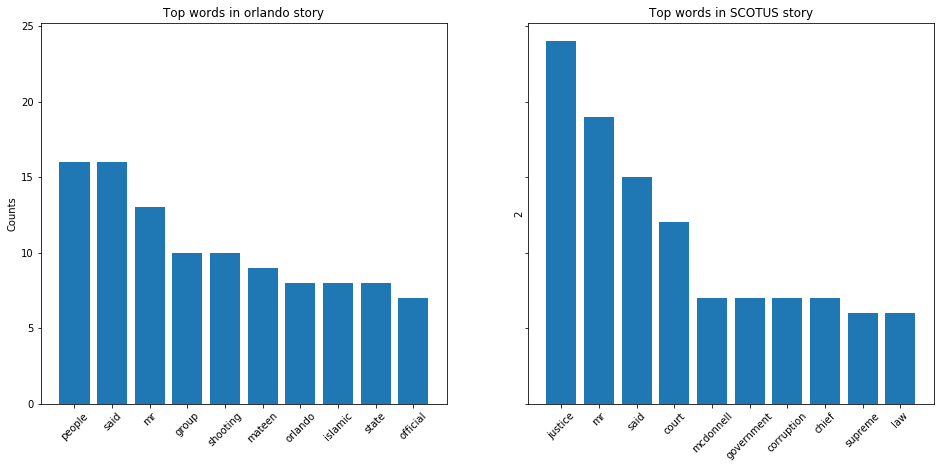

In [29]:
fig, axarr = plt.subplots(1,2,sharey='row', figsize=(16,7))

ax1 = axarr[0]
ax2 = axarr[1]

make_series_bar(ax1, series=top_orlando_counts, title='Top words in orlando story', ylabel='Counts')
make_series_bar(ax2, series=top_scotus_counts, title='Top words in SCOTUS story')

# plt.savefig('compare_orlando_tfidf_scores.png')
plt.show()

Ok now it's easy, right?

In [35]:
# import seaborn as sns

# d = pd.DataFrame([top_orlando_counts, top_scotus_counts], columns=['orlando','scotus'])
# g = sns.factorplot(x=d.index, y="survived", hue="sex", data=d,
#                    size=6, kind="bar", palette="muted")

ValueError: Could not interpret input 'survived'